In [1]:
using JuMP, Clp, Plots

In [2]:
N = 1
d = collect(60:N:150)
p = (1/size(d,1))*ones(size(d,1));
λ = 0.9
ω_list = collect(0.0:0.1:1.0)

11-element Vector{Float64}:
 0.0
 0.1
 0.2
 0.3
 0.4
 0.5
 0.6
 0.7
 0.8
 0.9
 1.0

In [3]:
function Q(x,ξ)
    m = Model(Clp.Optimizer)
    set_optimizer_attribute(m, "LogLevel",0)
    @variables(m, 
    begin
        y ≥ 0
        w ≥ 0
    end)

    @constraints(m,
    begin
        y ≤ ξ
        aux, y + w ≤ x
    end)

    @objective(m, Min, -25 * y - 5 * w)
    optimize!(m)
    return objective_value(m), shadow_price(aux)
end

Q (generic function with 1 method)

In [4]:
function cvar(q_list)
    c = Model(Clp.Optimizer)
    set_optimizer_attribute(c, "LogLevel",0)
    @variables(c, 
    begin
        q[1:size(q_list,1)] ≥ 0
    end)

    @constraints(c,
    begin
        sum(q[s] for s = 1:size(q_list,1)) == 1
        aux[s=1:size(q_list,1)], q[s] ≤ (p[s]/(1-λ))
    end)

    @objective(c, Max, sum(q[s]*q_list[s] for s = 1:size(q_list,1)))
    optimize!(c)
    return value.(q)
end 

cvar (generic function with 1 method)

=========== ω = 0.0 ===========
Iteration 1: x̂1: 0.0 | Lower Bound: -9999.0 & Uper Bound: 0.0
Iteration 2: x̂2: 150.0 | Lower Bound: -2249.999999999998 & Uper Bound: -1349.9999999999995
Iteration 3: x̂3: 105.00000000000004 | Lower Bound: -1574.9999999999995 & Uper Bound: -1347.5274725274708
Iteration 4: x̂4: 128.0000000000001 | Lower Bound: -1459.9999999999989 & Uper Bound: -1404.3956043956016
Iteration 5: x̂5: 116.99999999999984 | Lower Bound: -1406.2087912087884 & Uper Bound: -1391.7032967032935
Iteration 6: x̂6: 123.00000000000003 | Lower Bound: -1405.2197802197777 & Uper Bound: -1401.923076923075
Iteration 7: x̂7: 125.99999999999905 | Lower Bound: -1404.7252747252714 & Uper Bound: -1404.0659340659336
Iteration 8: x̂8: 127.499999999994 | Lower Bound: -1404.47802197802 & Uper Bound: -1404.3681318681301
**SOLUTION FOUND**
Iteration 9: x̂9: 127.99999999999181 | Lower Bound: -1404.3956043956032 & Uper Bound: -1404.3956043956036
=========== ω = 0.1 ===========
Iteration 1: x̂1: 0.0 | Lo

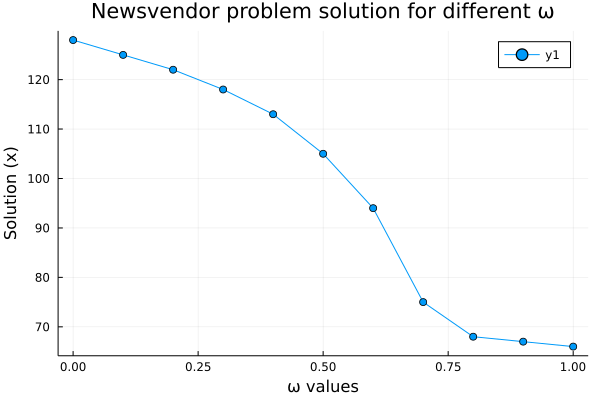


(process:8708): GLib-GIO-WARNING **: 22:28:04.388: Unexpectedly, UWP app `38526MediaLife.ZipPlus_2.0.4.0_x86__1crh1k73ty8mg' (AUMId `38526MediaLife.ZipPlus_1crh1k73ty8mg!ZipExtractor') supports 89 extensions but has no verbs


In [5]:
x_dict=Dict{Float64, Float64}();
for ω in 0.0:0.1:1.0
    println("=========== ω = $(ω) ===========")
    master = Model(Clp.Optimizer)
    set_optimizer_attribute(master, "LogLevel",0)
    @variable(master,x>=0)
    @variable(master,α)
    @constraint(master, α >= -9999)
    @constraint(master, x<=150)
    @objective(master, Min, 10*x + α)
    optimize!(master);

    iterator = 1
    Q̂i_list = []
    πi_list = []
    x̂i_list = []
    LB_list = []
    UB_list = []

    while true
        LB = objective_value(master)
        x̂i = value(x)
        append!(x̂i_list, x̂i)

        slave_Q̄i_list = []
        slave_πi_list = []
        for ξ in d
            q̂, pî = Q(x̂i,ξ)
            append!(slave_Q̄i_list, q̂)
            append!(slave_πi_list, pî)
        end

        p_alt = cvar(slave_Q̄i_list)

        Q̂i = sum(((1-ω) * p[s] + ω * p_alt[s]) * slave_Q̄i_list[s] for s = 1:size(d,1))
        πi = sum(((1-ω) * p[s] + ω * p_alt[s]) * slave_πi_list[s] for s = 1:size(d,1))


        l_i = x-> Q̂i + πi*(x-x̂i)
        append!(Q̂i_list, Q̂i)
        append!(πi_list, πi)

        UB = 10*x̂i + sum(((1-ω) * p[s] + ω * p_alt[s]) * slave_Q̄i_list[s] for s = 1:size(d,1))  
        append!(LB_list, LB)
        append!(UB_list, UB)

        if trunc(LB, digits=5) == trunc(UB, digits=5)
            push!(x_dict, ω => x̂i)
            println("**SOLUTION FOUND**")
            println( "Iteration $(iterator): x̂$(iterator): $(x̂i) | Lower Bound: $(LB) & Uper Bound: $(UB)")
            println("===========")
            break
        else
            println( "Iteration $(iterator): x̂$(iterator): $(x̂i) | Lower Bound: $(LB) & Uper Bound: $(UB)")
            println("===========")
        end  
        @constraint(master, α >= l_i(x))
        optimize!(master);

        iterator += 1
    end
end
plot(x=ω_list,x_dict, shape = :circle,title = "Newsvendor problem solution for different ω", xlabel = "ω values", ylabel = "Solution (x)")